<h1 style="color:black; background-color:#7cdff3; font-family:Helvetica;font-size:400%;text-align:center">Star Type Dataset - EDA and Classification </h1>

![Space](space_bar.png)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports-and-function-definitions" data-toc-modified-id="Imports-and-function-definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports and function definitions</a></span></li><li><span><a href="#Data-loading-and-exploration" data-toc-modified-id="Data-loading-and-exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data loading and exploration</a></span><ul class="toc-item"><li><span><a href="#Reading-data-into-a-DataFrame" data-toc-modified-id="Reading-data-into-a-DataFrame-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Reading data into a DataFrame</a></span></li><li><span><a href="#Basic-information" data-toc-modified-id="Basic-information-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Basic information</a></span></li><li><span><a href="#Null-value-and-type-checking" data-toc-modified-id="Null-value-and-type-checking-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Null-value and type checking</a></span></li></ul></li><li><span><a href="#Variable-exploration" data-toc-modified-id="Variable-exploration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variable exploration</a></span><ul class="toc-item"><li><span><a href="#Target-variable-exploration" data-toc-modified-id="Target-variable-exploration-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Target variable exploration</a></span><ul class="toc-item"><li><span><a href="#Target-variable-distribution" data-toc-modified-id="Target-variable-distribution-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Target variable distribution</a></span></li></ul></li><li><span><a href="#Numerical-variable-exploration-and-preliminary-feature-engineering" data-toc-modified-id="Numerical-variable-exploration-and-preliminary-feature-engineering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Numerical variable exploration and preliminary feature engineering</a></span><ul class="toc-item"><li><span><a href="#Basic-information" data-toc-modified-id="Basic-information-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Basic information</a></span></li><li><span><a href="#Boxplots" data-toc-modified-id="Boxplots-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Boxplots</a></span></li><li><span><a href="#Histograms" data-toc-modified-id="Histograms-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Histograms</a></span></li><li><span><a href="#Boxplots-per-target-variable-values" data-toc-modified-id="Boxplots-per-target-variable-values-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Boxplots per target variable values</a></span></li></ul></li><li><span><a href="#Categorical-variable-exploration" data-toc-modified-id="Categorical-variable-exploration-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Categorical variable exploration</a></span><ul class="toc-item"><li><span><a href="#Basic-information" data-toc-modified-id="Basic-information-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Basic information</a></span></li><li><span><a href="#Unique-values-of-Color" data-toc-modified-id="Unique-values-of-Color-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Unique values of Color</a></span></li><li><span><a href="#Color-value-remapping" data-toc-modified-id="Color-value-remapping-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Color value remapping</a></span></li><li><span><a href="#Countplot-of-Color-variable" data-toc-modified-id="Countplot-of-Color-variable-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>Countplot of Color variable</a></span></li><li><span><a href="#Color-variable-encoding" data-toc-modified-id="Color-variable-encoding-4.3.5"><span class="toc-item-num">4.3.5&nbsp;&nbsp;</span>Color variable encoding</a></span></li><li><span><a href="#Unique-values-of-Spectral_Class" data-toc-modified-id="Unique-values-of-Spectral_Class-4.3.6"><span class="toc-item-num">4.3.6&nbsp;&nbsp;</span>Unique values of Spectral_Class</a></span></li><li><span><a href="#Countplot-of-Spectral_Class-variable" data-toc-modified-id="Countplot-of-Spectral_Class-variable-4.3.7"><span class="toc-item-num">4.3.7&nbsp;&nbsp;</span>Countplot of Spectral_Class variable</a></span></li><li><span><a href="#Spectral_Class-variable-encoding" data-toc-modified-id="Spectral_Class-variable-encoding-4.3.8"><span class="toc-item-num">4.3.8&nbsp;&nbsp;</span>Spectral_Class variable encoding</a></span></li></ul></li><li><span><a href="#Countplots-per-target-variable-values" data-toc-modified-id="Countplots-per-target-variable-values-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Countplots per target variable values</a></span></li><li><span><a href="#Variable-correlations" data-toc-modified-id="Variable-correlations-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Variable correlations</a></span><ul class="toc-item"><li><span><a href="#Pearson-heatmap" data-toc-modified-id="Pearson-heatmap-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Pearson heatmap</a></span></li><li><span><a href="#Correlation-pairplot" data-toc-modified-id="Correlation-pairplot-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Correlation pairplot</a></span></li></ul></li></ul></li><li><span><a href="#Final-feature-engineering" data-toc-modified-id="Final-feature-engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final feature engineering</a></span><ul class="toc-item"><li><span><a href="#Removal-of-non-encoded-versions-of-categorical-variables" data-toc-modified-id="Removal-of-non-encoded-versions-of-categorical-variables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Removal of non-encoded versions of categorical variables</a></span></li><li><span><a href="#Target-and-feature-separation" data-toc-modified-id="Target-and-feature-separation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Target and feature separation</a></span></li><li><span><a href="#Data-split-into-train-and-test-sets" data-toc-modified-id="Data-split-into-train-and-test-sets-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Data split into train and test sets</a></span></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model training</a></span><ul class="toc-item"><li><span><a href="#Default-RandomForestClassifier" data-toc-modified-id="Default-RandomForestClassifier-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Default RandomForestClassifier</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Feature importance</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Introduction

This notebook contains an **Exploratory Data Analysis** of the [Star Type Classification / NASA Dataset](https://www.kaggle.com/brsdincer/star-type-classification) and a **RandomForestClassifier** model for prediction of star types.

**The dataset**

The [Star Type Classification / NASA Dataset](https://www.kaggle.com/brsdincer/star-type-classification) contains various information about stars, such as their tempearture, colour or radius. This data can be used for training classification and regression models.

**Objectives**

The main objective of this notebook is to explore all of the variables contained in the dataset and present relevant observations.
Afterwards, I will perform feature engineering in order to transform the data into a form suitable for the RandomForestClassifier. Lastly, I will train the classifier to **predict Star Types** and analyse the results.

## Imports and function definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
import plotly
import math
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
#Function used to add value labels to vertical barplots 

def add_val_labels(plot, spacing=float(0.5)):
    for p in plot.patches:
        if not math.isnan(p.get_height()):
            x = p.get_x() + p.get_width()- float(0.45)
            y = p.get_height() - spacing
            value = round(p.get_height(), 1)
            plot.text(x, y, value, ha="left", color="black", size='large')

## Data loading and exploration

### Reading data into a DataFrame

In [3]:
df = pd.read_csv("Stars.csv")

### Basic information

In [4]:
df.shape

(240, 7)

**Observations:**

- This dataset is small, containing only 240 rows

- It contains 7 columns

In [5]:
df.columns

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

In [6]:
df.head(-10)

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.120,Red,M,0
1,3042,0.000500,0.1542,16.600,Red,M,0
2,2600,0.000300,0.1020,18.700,Red,M,0
3,2800,0.000200,0.1600,16.650,Red,M,0
4,1939,0.000138,0.1030,20.060,Red,M,0
...,...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,Blue,O,4
226,9892,593900.000000,80.0000,-7.262,Blue,O,4
227,10930,783930.000000,25.0000,-6.224,Blue,O,4
228,23095,347820.000000,86.0000,-5.905,Blue,O,4


**Column definitions:**
- Temperature - Temperature of the star, expressed in degrees of Kelvin: (K)
- L - Relative luminosity, expressed in terms of nominal solar luminosity: (L/L⊙)
- R - Relative radius, expressed in terms of nominal solar radius: (R/R⊙)
- A_M - Absolute magnitude, expressed in: (Mv)
- Color - Observable color of the star
- Spectral_Class - Spectral class of the star, classified under the Morgan–Keenan (MK) system
- Type - Type of the star:
    - Red Dwarf - 0
    - Brown Dwarf - 1
    - White Dwarf - 2
    - Main Sequence - 3
    - Super Giant - 4
    - Hyper Giant - 5


### Null-value and type checking

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


**Observations:**

- There is no null values

- 4 columns contain numerical values: 
    - Temperature (int64)
    - L (float64)
    - R (float64)
    - A_M (float64)

- 3 columns contain categorical values: 
    - Color (object)
    - Spectral_Class (object)
    - Type (int64)

- Target variable is Type 

## Variable exploration

### Target variable exploration

#### Target variable distribution

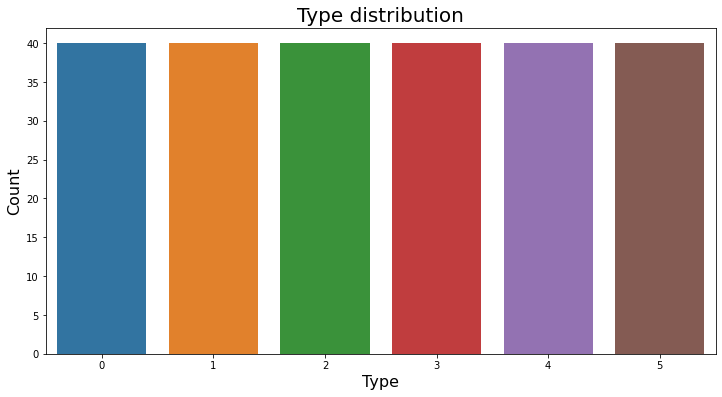

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x="Type", data=df)
plt.title("Type distribution", fontsize=20)
plt.xlabel("Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**Observations:**

- There is an equal number of rows corresponding to each star Type - Classes are completely balanced

- Each of the 6 types has 40 corresponding observations

###  Numerical variable exploration and preliminary feature engineering

#### Basic information

In [9]:
df_vars_num = df.loc[:, ["Temperature", "L", "R", "A_M"]]
df_vars_num.describe()

,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


**Observations:**

- Variables Temperature, L, R appear to be skewed and may contain outliers. It can be confirmed by observing boxplots and histograms.

#### Boxplots

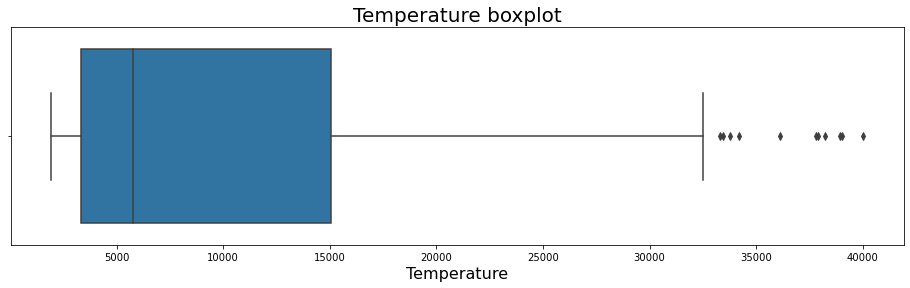

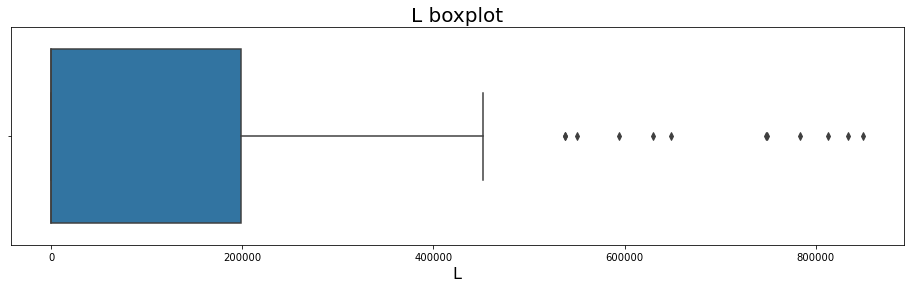

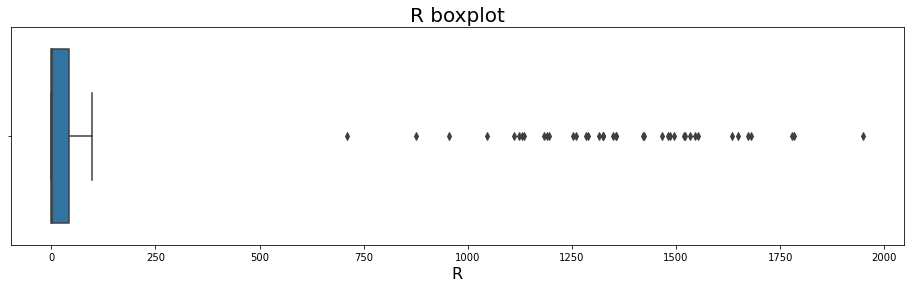

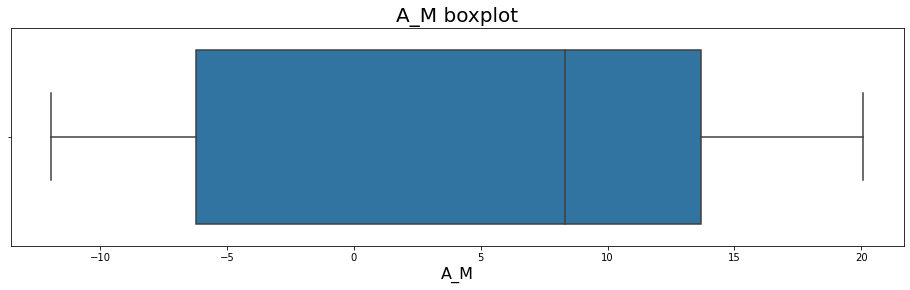

In [10]:
for col_name in df_vars_num:
    plt.figure(figsize=(16, 4))
    sns.boxplot(x=df_vars_num[col_name])
    plt.title(col_name+ " boxplot", fontsize=20)
    plt.xlabel(col_name, fontsize=16)
    plt.xticks(fontsize=10)
    plt.show()

**Observations:**

- Temperature, L and R variables contain outliers

#### Histograms

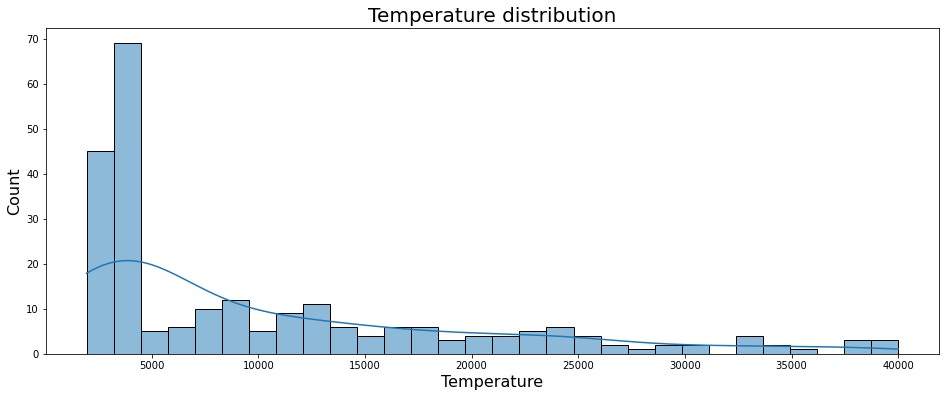

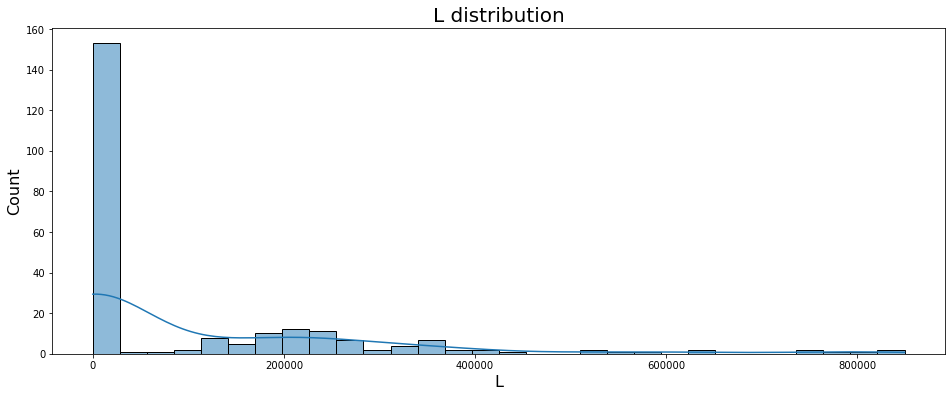

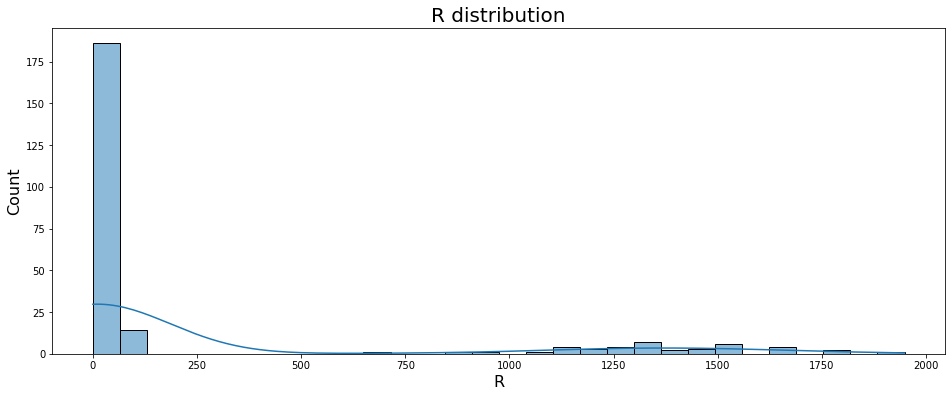

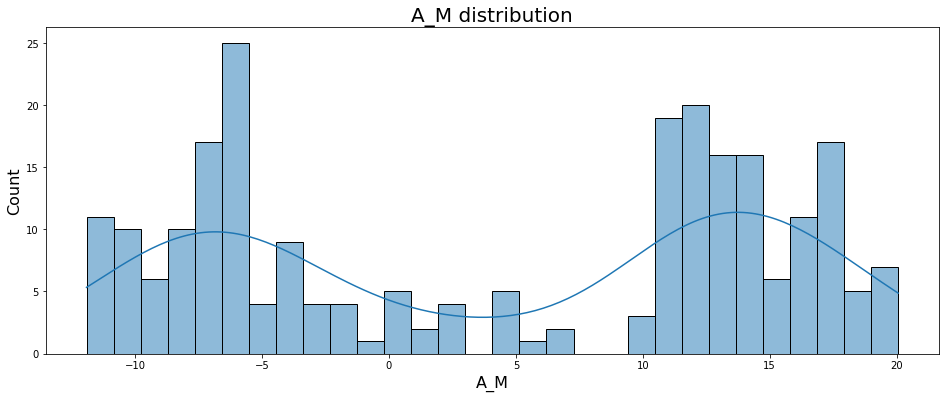

In [11]:
for col_name in df_vars_num:
    
    plt.figure(figsize=(16, 6))
    sns.histplot(x=col_name, kde=True, bins=30, data=df_vars_num)
    plt.title(col_name+ " distribution", fontsize=20)
    plt.xlabel(col_name, fontsize=16)
    plt.ylabel("Count", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

**Obesrvations:**

- None of the numerical variables follow the Gaussian distribution

- For Temperature, L and R variables - Great majority of the values is contained on the far left edge of the distribution

- For A_M variables - Majority of the values is contained on the left and right sides of the distribtuion

#### Boxplots per target variable values

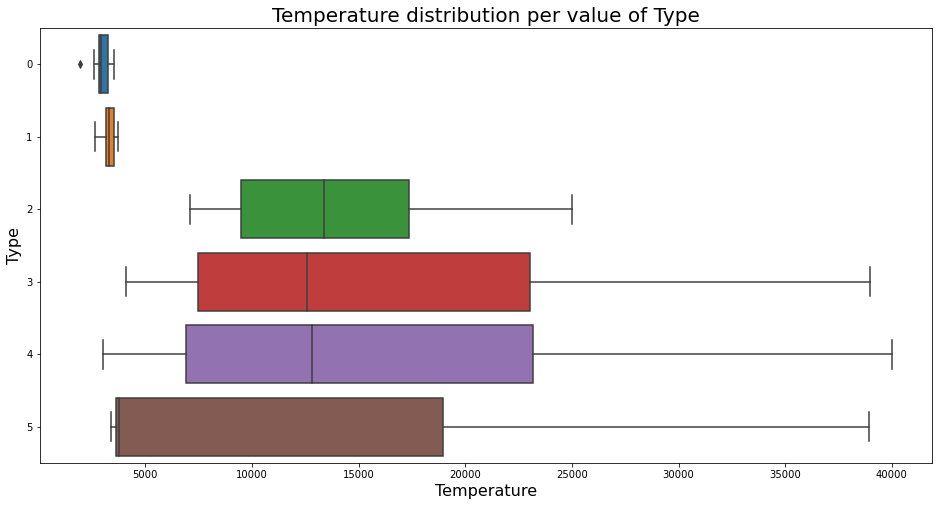

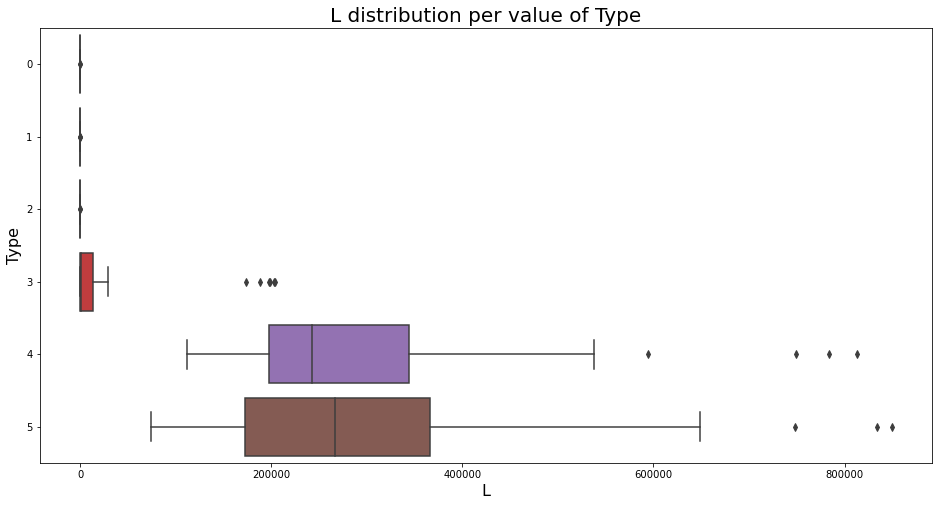

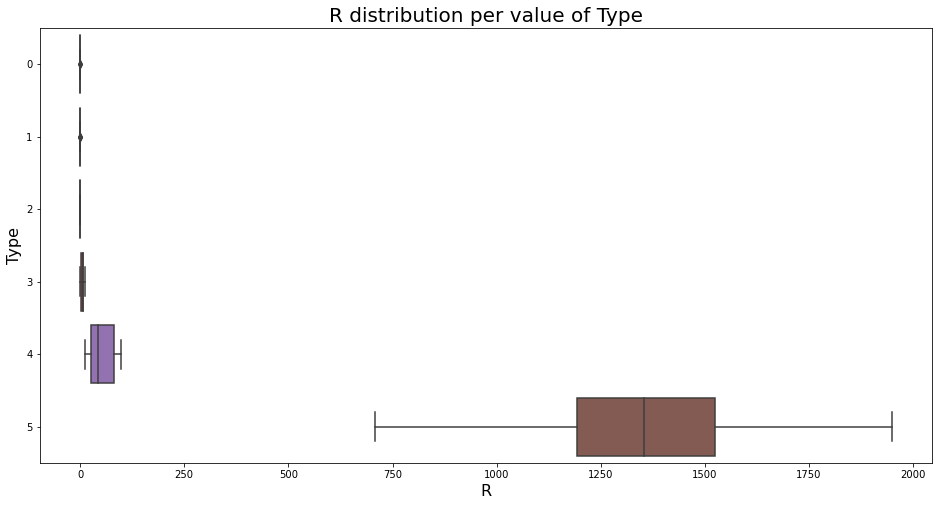

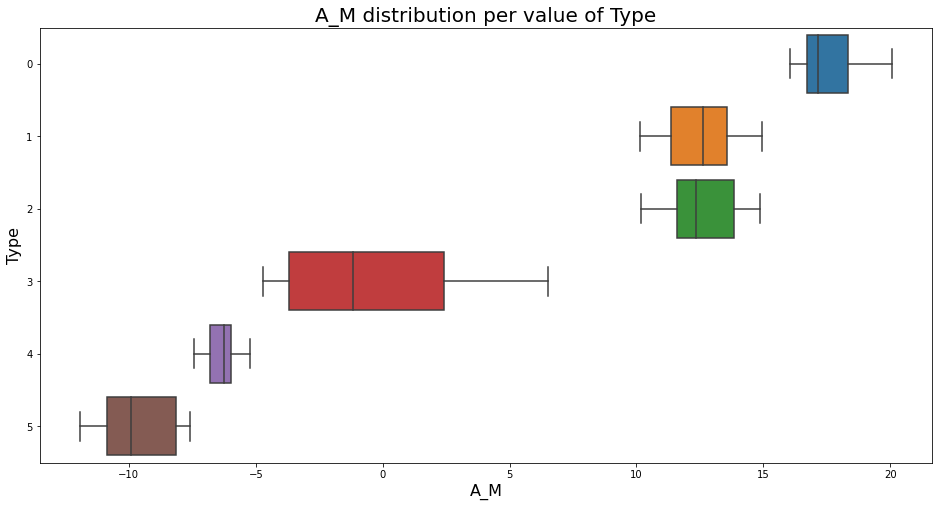

In [12]:
for col_name in df_vars_num:
    plt.figure(figsize=(16, 8))
    sns.boxplot(y="Type", x=col_name, data=df, orient="h")
    plt.title(col_name+ " distribution per value of Type", fontsize=20)
    plt.xlabel(col_name, fontsize=16)
    plt.ylabel("Type", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

**Observations:**

- All stars of Type 0 and 1 have temperature below 5000

- Stars of types 0-2 have much lower luminosity than those of types 4-5. Majority of type 3 stars also has much lower luminosity, excluding a few outliers.

- Stars of type 5 have much larger radius than other types

- Absolute magnintude (A_M) seems to gradually get lower for stars of higher type

### Categorical variable exploration

#### Basic information

In [13]:
df_vars_cat = df.loc[:, ["Color", "Spectral_Class"]]
df_vars_cat.describe()

,Color,Spectral_Class
count,240,240
unique,17,7
top,Red,M
freq,112,111


**Observations:**

- There is 17 unique values of Color and 7 unique values of Spectral_Class

- Red is the most common color and it appears 112 times

- M is the most common spectral class and it appears 111 times

#### Unique values of Color

In [14]:
df["Color"].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

![Star Colours](https://i.stack.imgur.com/XyJyp.jpg)

**Observations**

- It can be noticed that there's several values that are almost exactly the same, namely:

    - "yellowish", "Yellowish", "Yellow"
    
    - "Blue White", "Blue white", "Blue-white", "Blue-White"
    
    - "yellow-white" and "White-Yellow"
    
    - "white", "White", "Whitish"
    
- Similar values mentioned above can be remapped to eliminate redundancy

- As can be observed on the above image, star colours are strongly correlated with temperatures. Because of this, we can transform this categorical variable using a technique of label encoding, so that stars with "colder" colours get lower values and stars with "hotter" colours get higher values. This will allow us to treat "Color" as if it was an ordinal variable

- We will change the name of "Color" column to "Color_name" and use the name "Color" for the newly created label-encoded column instead


#### Color value remapping

In [15]:
remap_dict = {
    'Red': 'Red',
    'Blue White': 'Blue-White',
    'White': 'White',
    'Yellowish White': 'White-Yellow',
    'Blue white': 'Blue-White',
    'Pale yellow orange': 'Yellow-Orange',
    'Blue': 'Blue',
    'Blue-white': 'Blue-White',
    'Whitish': 'White',
    'yellow-white': 'White-Yellow',
    'Orange': 'Orange',
    'White-Yellow': 'White-Yellow',
    'white': 'White',
    'yellowish': 'Yellow',
    'Yellowish': 'Yellow',
    'Orange-Red': 'Orange-Red',
    'Blue-White': 'Blue-White'
}

df["Color_name"] = df["Color"].map(remap_dict)
df["Color_name"].unique()

array(['Red', 'Blue-White', 'White', 'White-Yellow', 'Yellow-Orange',
       'Blue', 'Orange', 'Yellow', 'Orange-Red'], dtype=object)

**Observations:**
- By remapping Color values, total number of unique values has been reduced from 17 to 9

#### Countplot of Color variable

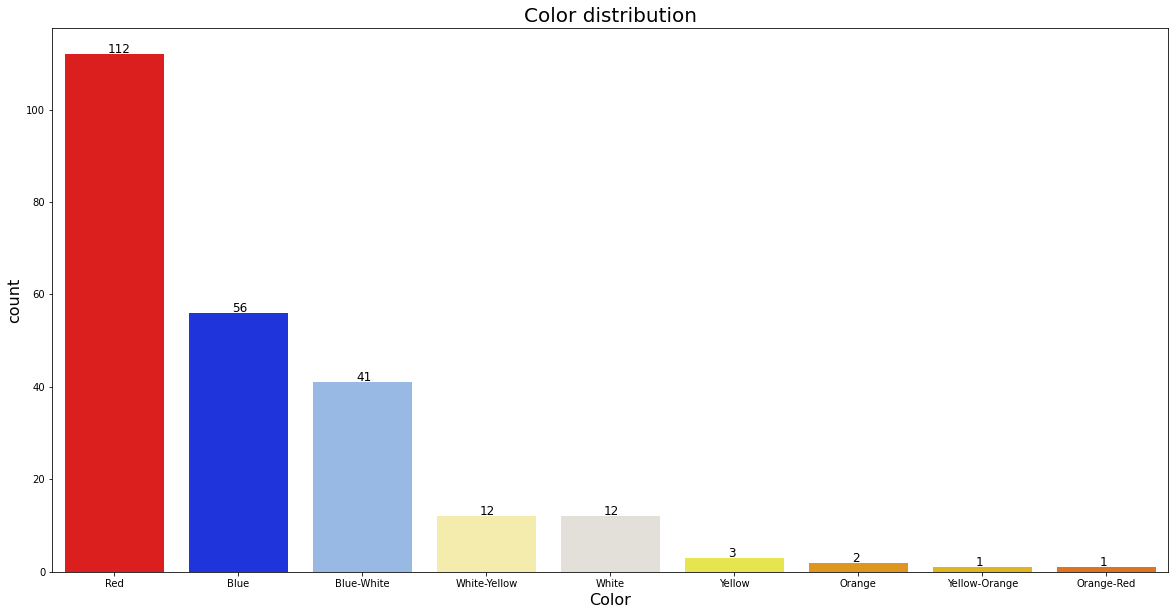

In [16]:
plt.figure(figsize=(20, 10))
palette = {"Red": "#fa0000", "Blue": "#001dfa", "Blue-White": "#8bb7f0", "White": "#e3e1d8",
           "White-Yellow": "#fff6a1", "Yellow": "#fffc36", "Orange": "#ff9d00", "Orange-Red": "#ff6f00",
           "Yellow-Orange": "#ffc800"}
plot = sns.countplot(x="Color_name", data=df,
              order=df["Color_name"].value_counts().index, palette=palette)
plt.title("Color distribution", fontsize=20)
plt.xlabel("Color", fontsize=16)
plt.ylabel("count", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
add_val_labels(plot, spacing=float(-0.2))
plt.show()

**Observations:**

- Red is the most common colour, Orange-Red and Yellow-Orange are the least common (each have only 1 occurence).


#### Color variable encoding

In [17]:
remap_dict_2 = {
    "Red": 0,
    "Orange-Red": 1,
    "Orange": 2,
    "Yellow-Orange": 3,
    "Yellow": 4,
    "White-Yellow": 5,
    "White": 6,
    "Blue-White": 7,
    "Blue": 8
}

df["Color"] = df["Color_name"].map(remap_dict_2)
df["Color"].unique()

array([0, 7, 6, 5, 3, 8, 2, 4, 1], dtype=int64)

**Observations:**

- After encoding, Color is an ordinal variable with values ranging from 0 to 8

#### Unique values of Spectral_Class

In [18]:
df["Spectral_Class"].unique()

array(['M', 'B', 'A', 'F', 'O', 'K', 'G'], dtype=object)

**Observations:**
- Spectral_Class has 7 unique values

- According to the Wikipedia article on Stellar classification (https://en.wikipedia.org/wiki/Stellar_classification):

        "Most stars are currently classified under the Morgan–Keenan (MK) system using the letters O, B, A, F, G, K, and M, a sequence from the hottest (O type) to the coolest (M type)."
        
    With that knowledge in mind, we can encode this variable in a similar way to how we encoded the Color variable.

#### Countplot of Spectral_Class variable

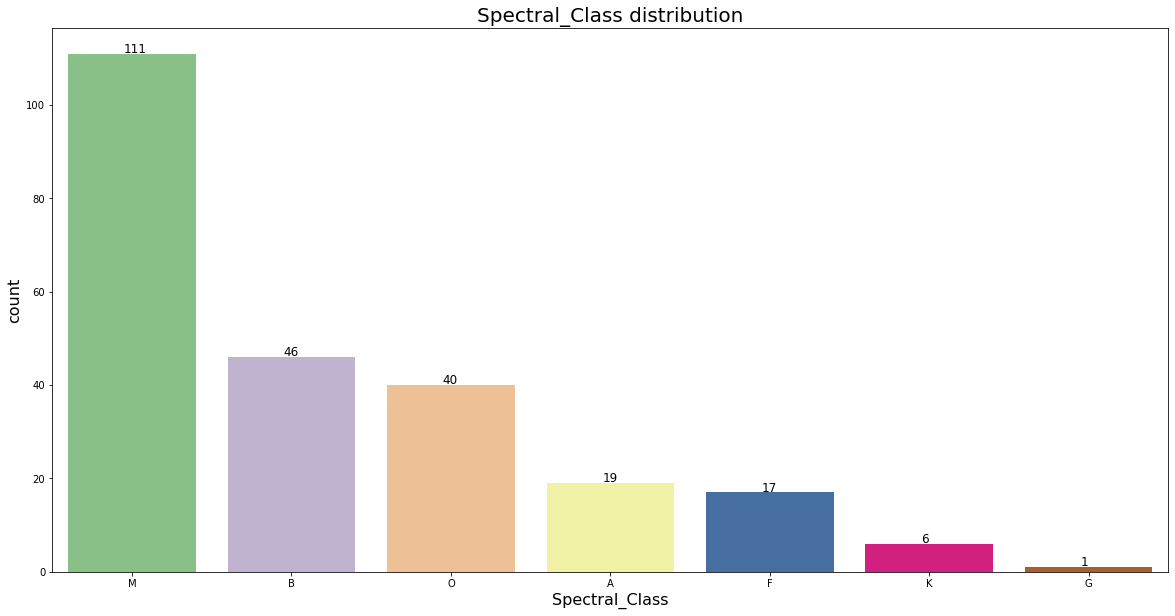

In [19]:
plt.figure(figsize=(20, 10))
plot = sns.countplot(x="Spectral_Class", data=df,
              order=df['Spectral_Class'].value_counts().index, palette="Accent")
plt.title("Spectral_Class distribution", fontsize=20)
plt.xlabel("Spectral_Class", fontsize=16)
plt.ylabel("count", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
add_val_labels(plot, spacing=float(-0.2))
plt.show()

**Observations:**

- M is the most common spectral class and G is the least common (only a single occurence)


#### Spectral_Class variable encoding

In [20]:
df["Spectral_Class_name"] = df["Spectral_Class"]

remap_dict_3 = {
    "M": 0,
    "K": 1,
    "G": 2,
    "F": 3,
    "A": 4,
    "B": 5,
    "O": 6
}

df["Spectral_Class"] = df["Spectral_Class_name"].map(remap_dict_3)
df["Spectral_Class"].unique()

array([0, 5, 4, 3, 6, 1, 2], dtype=int64)

**Observations:**

- After encoding, Spectral_Class is an ordinal variable with values ranging from 0 to 6

### Countplots per target variable values

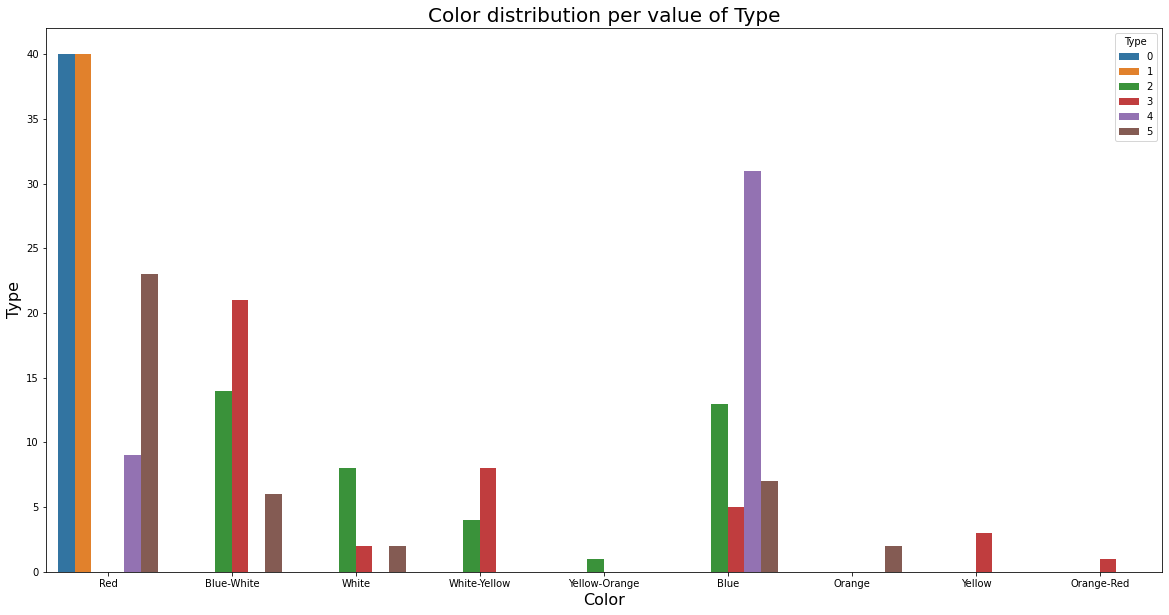

In [21]:
plt.figure(figsize=(20, 10))
sns.countplot(x="Color_name", hue="Type", data=df)
plt.title("Color distribution per value of Type", fontsize=20)
plt.xlabel("Color", fontsize=16)
plt.ylabel("Type", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**Observations**:

- Type 0 and 1 stars are exclusively Red

- No type 3 stars are Red

- All Yellow and Orange-Red stars are type 3

- All Yellow-Orange stars are type 2

- All Orange stars are type 5

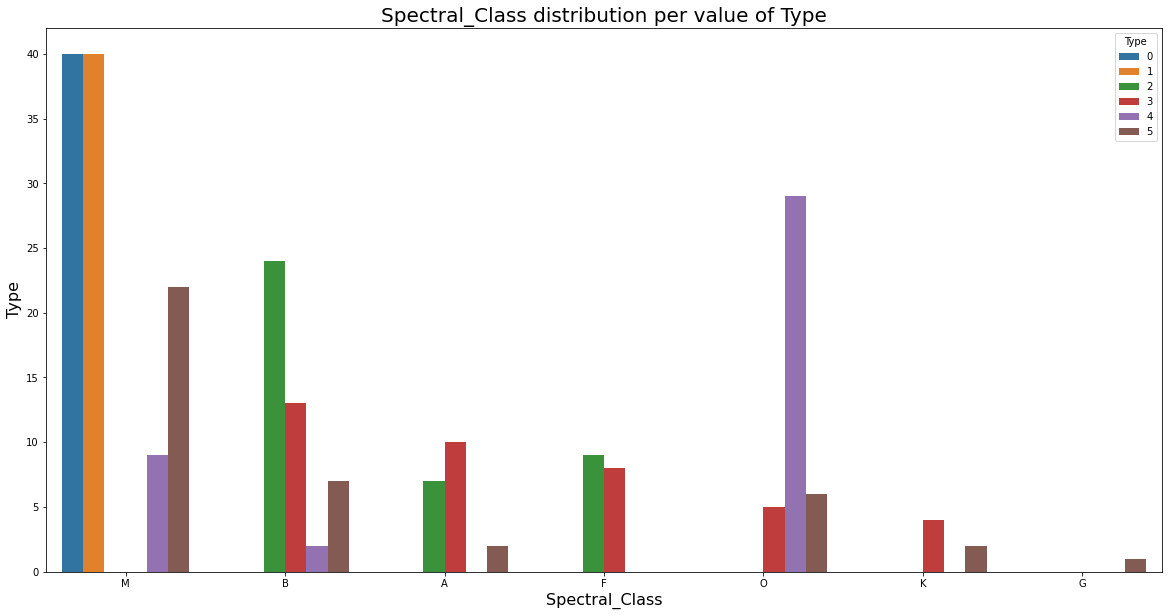

In [22]:
plt.figure(figsize=(20, 10))
sns.countplot(x="Spectral_Class_name", hue="Type", data=df)
plt.title("Spectral_Class distribution per value of Type", fontsize=20)
plt.xlabel("Spectral_Class", fontsize=16)
plt.ylabel("Type", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="upper right", title="Type")
plt.show()

**Observations**:

- Type 0 and 1 stars are exclusively Class M

- All Class G stars are Type 5

- Majority of Type 4 stars belong to class O

- Majority of Type 2 stars belong to class B

### Variable correlations

#### Pearson heatmap

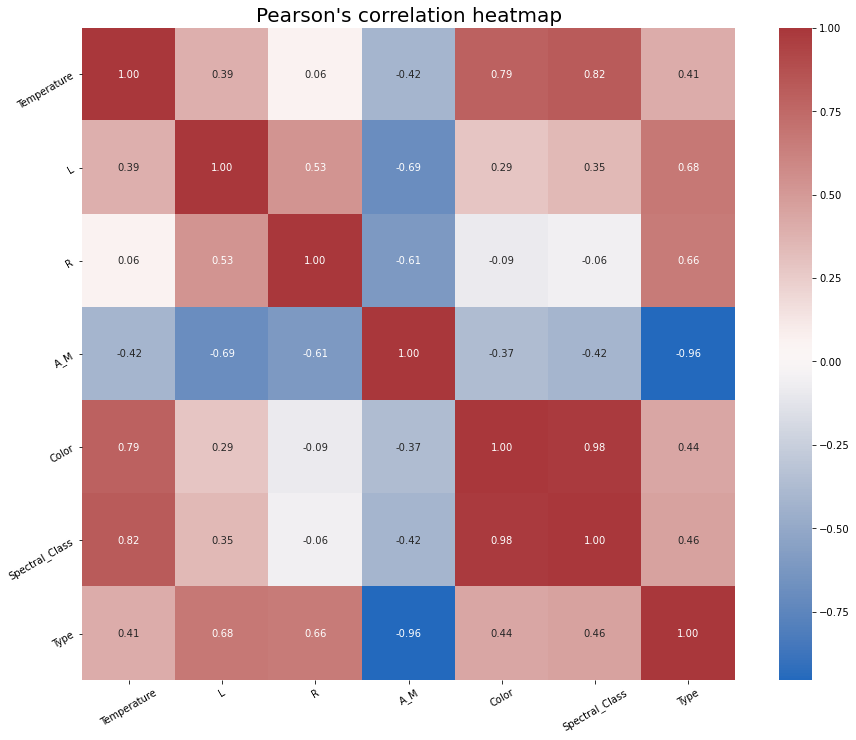

In [38]:
correlations = df.corr()
plt.figure(figsize=(16, 12))
ax = sns.heatmap(correlations, square=True, annot=True,
                 fmt='.2f', linecolor='white', cmap="vlag")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, fontsize=10)
plt.title("Pearson's correlation heatmap", fontsize=20)

plt.show()

**Observations:**

- A_M and Type are very heavily negatively correlated

- A_M and L, R are also negatively correlated

- Type and L, R are positively correlated

- L and R are positively correlated

- Color and Temperature are heavily positively correlated

- Spectral_Class and Temperature are heavily positively correlated

- Spectral_Class and Color are very heavily positively correlated

#### Correlation pairplot

<Figure size 1152x1152 with 0 Axes>

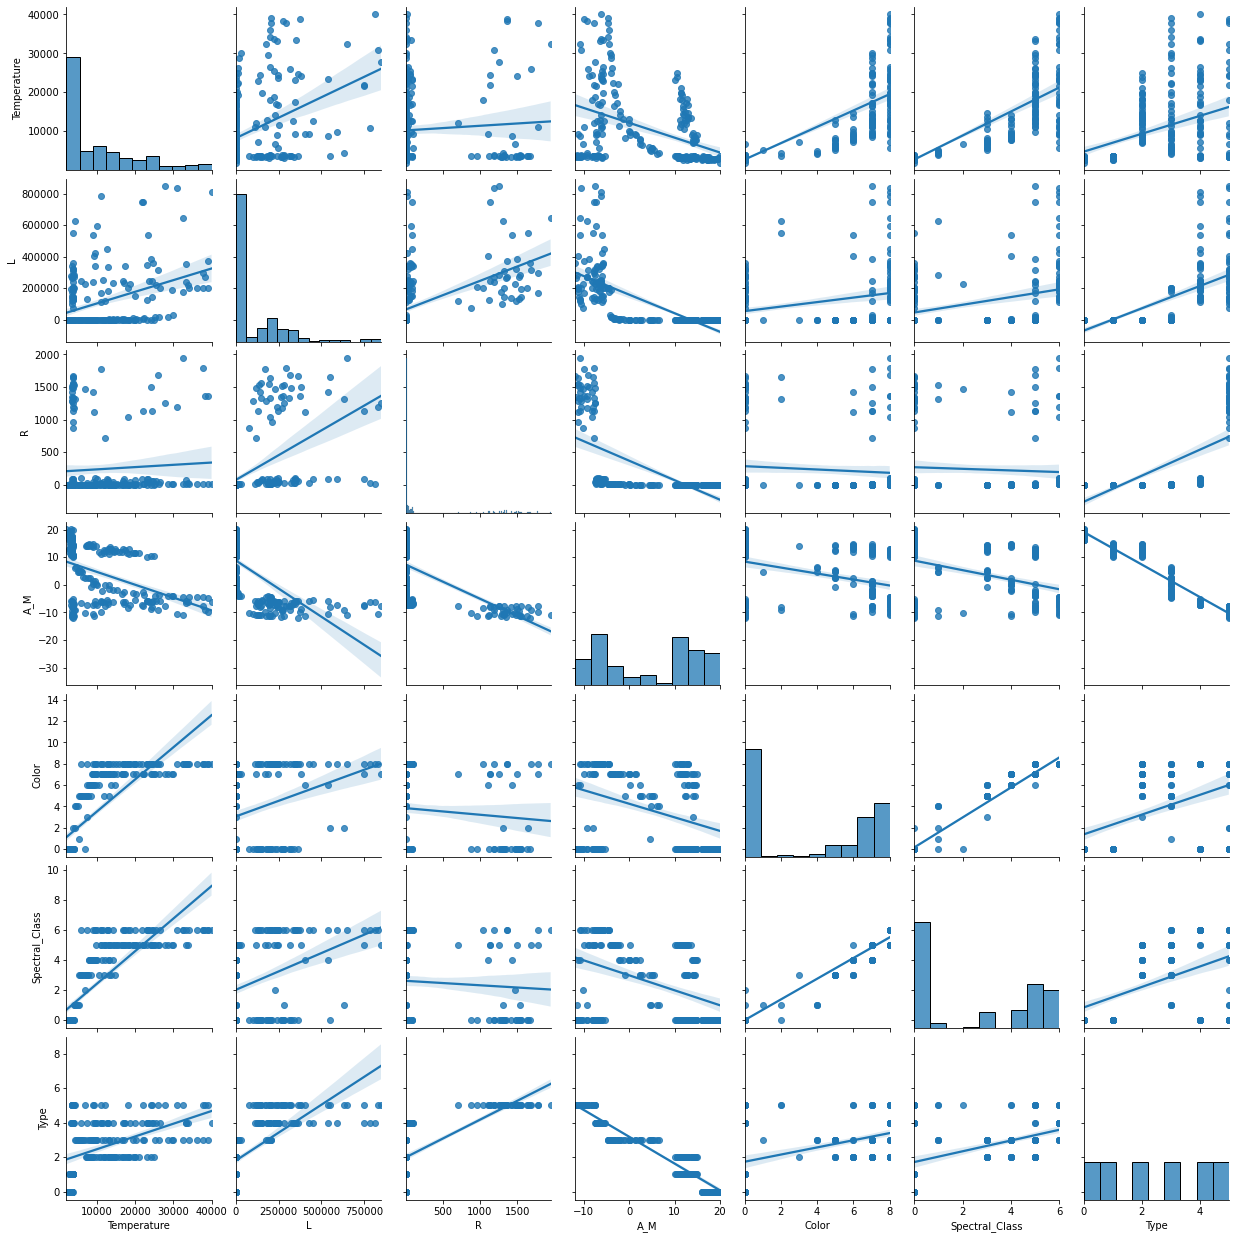

In [24]:
plt.figure(figsize=(16, 16))
sns.pairplot(df, kind='reg', diag_kind='hist', palette='Rainbow')
plt.show()

Thanks to the pairplot we can observe and confirm previously identified correlations. 

Heavy correlations between the target variable and features of the data (The first 3 observed) are desirable, while heavy correlations between different features (The last 3 observed) are not, because they may end up not providing any meaningful data, while increasing model's degrees of freedom, which may cause overfitting.

## Final feature engineering

### Removal of non-encoded versions of categorical variables

In [25]:
df = df.drop(["Color_name", "Spectral_Class_name"], axis=1)
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0


As we have previously encoded Color and Spectral_Class variables, transforming them into ordinal variables, we should drop their non-encoded versions.

### Target and feature separation

In [26]:
y = df["Type"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Type, dtype: int64

In [27]:
X = df.drop(["Type"], axis=1)
X.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0,0
1,3042,0.000500,0.1542,16.60,0,0
2,2600,0.000300,0.1020,18.70,0,0
3,2800,0.000200,0.1600,16.65,0,0
4,1939,0.000138,0.1030,20.06,0,0


### Data split into train and test sets 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144, 6) (96, 6) (144,) (96,)


**Observations:**

- Data has been split into a train and test dataset according to a 60/40 ratio

- Training set contains 144 observations and testing set contains 96

## Model training

### Default RandomForestClassifier

In [29]:
rfc_model = RandomForestClassifier(random_state=1)

rfc_model.fit(X_train, y_train)

y_pred_1 = rfc_model.predict(X_test)

score_1 = accuracy_score(y_test, y_pred_1)

print("Accuracy of default RandomForestClassifier = "+str(score_1))

Accuracy of default RandomForestClassifier = 1.0


Using just the default RandomForestClassifier model we're able to achieve perfect accuracy. This is most likely caused by following:

- High correlation values of all features with the target variable

- Relatively large ratio of observations to possible target classes 

It is very important to note, however that our trained model is not perfect and will not always have perfect accuracy on new data, because:

- The amount of training observations was quite low (only 144)

- Several categorical feature values only appeared a few times (Such as Colors: Orange-Red, Yellow-Orange)

This flaw can be easily observed by changing the random_state variable of our train_test_split:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=47)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144, 6) (96, 6) (144,) (96,)


In [31]:
rfc_model2 = RandomForestClassifier(random_state=1)

rfc_model2.fit(X_train, y_train)

y_pred_2 = rfc_model2.predict(X_test)

score_2 = accuracy_score(y_test, y_pred_2)

print("Accuracy of default RandomForestClassifier with random_state of train_test_split changed = "+str(score_2))

Accuracy of default RandomForestClassifier with random_state of train_test_split changed = 0.9895833333333334


**Observations:**

- After changing a usually insignificant parameter (random_state of train_test_split), accuracy goes down by around 1%

- Despite that, this model makes the best possible use of the available data and can be used for making predictions on new data

- Further optimization is therefore unnecessary

### Feature importance

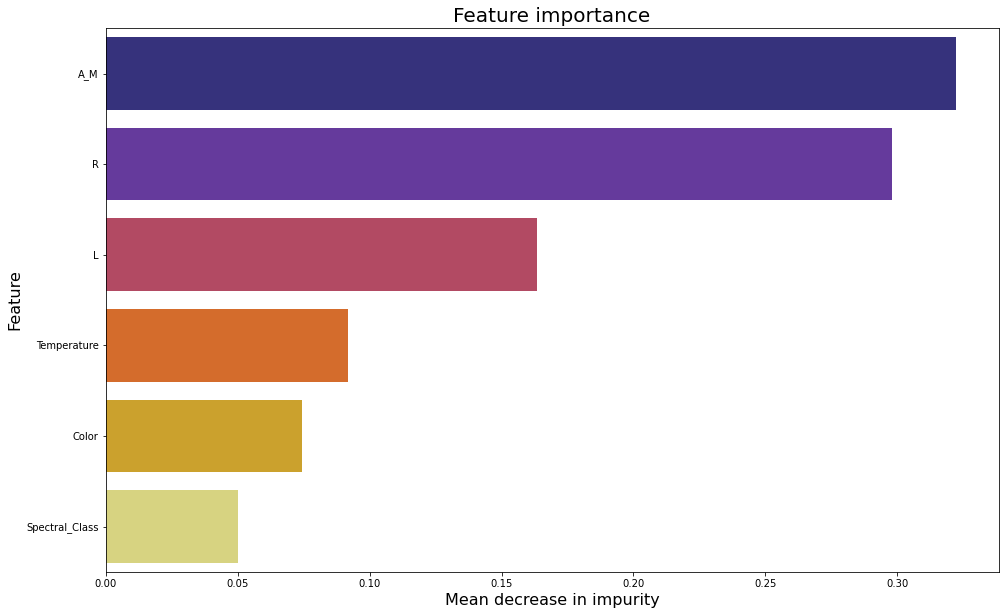

In [36]:
feature_importance = pd.Series(
    rfc_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="CMRmap")
plt.title("Feature importance", fontsize=20)
plt.xlabel("Mean decrease in impurity", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**Observations:**

- Features A_M and R together contribute to over 60% of the mean decrease in impurity

- Feature Spectral_Class is not very significant compared to all the others, providing only a 5% decrease in impurity

## Summary

- **Analysed dataset contains information about 240 different stars divided into 7 features: 'Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'**


- **'Type' is the target variable**


- **Target variable's distribution is perfectly balanced**


- **All of the numerical features are heavily skewed and most contain outliers, though they ended up not affecting the predictive model negatively**


- **Both categorical features may be expressed as ordinal features, potentially increasing model's accuracy**


- **All of the features have at least a slight degree of correlation with the target variable**


- **A default RandomForestClassifier model trained on entirety of the data after feature engineering was able to achieve accuracy of** <span style="color:green; font-weight:bold">100%</span>

<h1 style="color:black; background-color:#7cdff3; font-family:Helvetica;font-size:200%;text-align:center">Thank you for your attention! </h1>

![Space](space_bar.png)